# 05 - Analysis and Visualization

This notebook provides comprehensive analysis and visualization of the trained LDA model.

## Contents
- Topic exploration (word clouds, top words)
- pyLDAvis interactive visualization
- Topic trends over time
- Document similarity
- Topic comparison

In [24]:
# Import required libraries
import sys
import pickle
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.config import get_settings
from src.lda_model import LDATopicModel
from src.analysis import TopicAnalyzer
from src.visualizations import TopicVisualizer

In [25]:
# Load settings
settings = get_settings()

# Load model
print("Loading model...")
model = LDATopicModel(settings)
model.load()

print(f"Loaded model with {model.model.num_topics} topics")

INFO:gensim.utils:loading LdaMulticore object from C:\Users\alifn\PycharmProjects\topic-modeling-utama\models\lda_model.model
INFO:gensim.utils:loading expElogbeta from C:\Users\alifn\PycharmProjects\topic-modeling-utama\models\lda_model.model.expElogbeta.npy with mmap=None
INFO:gensim.utils:setting ignored attribute state to None
INFO:gensim.utils:setting ignored attribute dispatcher to None
INFO:gensim.utils:setting ignored attribute id2word to None
INFO:gensim.utils:LdaMulticore lifecycle event {'fname': 'C:\\Users\\alifn\\PycharmProjects\\topic-modeling-utama\\models\\lda_model.model', 'datetime': '2025-12-13T05:18:27.444796', 'gensim': '4.4.0', 'python': '3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26200-SP0', 'event': 'loaded'}
INFO:gensim.utils:loading LdaState object from C:\Users\alifn\PycharmProjects\topic-modeling-utama\models\lda_model.model.state


Loading model...


INFO:gensim.utils:LdaState lifecycle event {'fname': 'C:\\Users\\alifn\\PycharmProjects\\topic-modeling-utama\\models\\lda_model.model.state', 'datetime': '2025-12-13T05:18:27.509294', 'gensim': '4.4.0', 'python': '3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26200-SP0', 'event': 'loaded'}
INFO:gensim.utils:loading Dictionary object from C:\Users\alifn\PycharmProjects\topic-modeling-utama\models\dictionary.pkl
INFO:gensim.utils:Dictionary lifecycle event {'fname': 'C:\\Users\\alifn\\PycharmProjects\\topic-modeling-utama\\models\\dictionary.pkl', 'datetime': '2025-12-13T05:18:27.682035', 'gensim': '4.4.0', 'python': '3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26200-SP0', 'event': 'loaded'}
INFO:gensim.corpora.indexedcorpus:loaded corpus index from C:\Users\alifn\PycharmProjects\topic-modeling-utama\models\corpus.mm.index
INFO:gensim.corpora._mmreade

Loaded model with 15 topics


In [26]:
# Load processed data
corpus_path = settings.processed_data_dir / settings.processed_corpus_file
with open(corpus_path, 'rb') as f:
    corpus_data = pickle.load(f)

processed_docs = corpus_data['documents']
df = corpus_data['dataframe']

print(f"Loaded {len(processed_docs):,} documents")

Loaded 12,055 documents


In [27]:
# Initialize analyzer and visualizer
analyzer = TopicAnalyzer(model, settings)
visualizer = TopicVisualizer(model, settings)

# Set document data for analysis
analyzer.set_document_data(df, tokens_column='tokens')

print("Analyzer and Visualizer initialized")

Computing topic distributions: 100%|██████████| 12055/12055 [00:09<00:00, 1280.37it/s]

Analyzer and Visualizer initialized


## 1. Topic Overview

In [28]:
# Display all topics
topics = model.get_topics(num_words=20)

print(f"\n{len(topics)} Topics:")
print("=" * 70)

for topic in topics:
    print(f"\nTopic {topic.topic_id}: {', '.join(topic.top_words[:8])}")


15 Topics:

Topic 0: biaya, produksi, produk, persediaan, bahan_baku, pengendalian, biaya_produksi, barang

Topic 1: konsumen, keputusan_pembelian, kualitas_pelayanan, produk, harga, kualitas_produk, minat_beli, positif

Topic 2: good_corporate, governance, keuangan, manajemen_laba, terdaftar_bursa, kebijakan_dividen, ukuran, profitabilitas

Topic 3: sistem, aplikasi, informasi, media, pengguna, sistem_informasi, masyarakat, teknologi

Topic 4: keuangan, kinerja, laba, rasio, modal_kerja, arus_kas, informasi, kas

Topic 5: karya, sosial, film, bahasa, pegawai, fungsi, novel, kalimat

Topic 6: bank, saham, risiko, profitabilitas, bank_syariah, syariah, model, pengujian

Topic 7: penjualan, manajemen, akuntansi, sistem, sistem_informasi, pengendalian, memadai, pengendalian_internal

Topic 8: keuangan, kualitas, kinerja, audit, pemerintah, auditor, sistem, kota

Topic 9: pemberian_kredit, kredit, quality, used, effect, consumer, results, means

Topic 10: pajak, audit_internal, wajib_paja

In [29]:
# Topic prevalence
prevalence = analyzer.compute_topic_prevalence()
prevalence

,topic_id,mean_probability,std_probability,max_probability,num_dominant
0,0,0.065135,0.179488,0.991811,805
1,1,0.088301,0.235117,0.993898,1185
2,2,0.050475,0.158286,0.992022,571
3,3,0.090809,0.217843,0.994054,1178
4,4,0.055805,0.161409,0.992981,612
5,5,0.043238,0.163034,0.988330,417
6,6,0.052081,0.164772,0.993517,613
7,7,0.076178,0.185608,0.991739,933
8,8,0.072908,0.202199,0.989742,915
9,9,0.025049,0.112753,0.991812,273


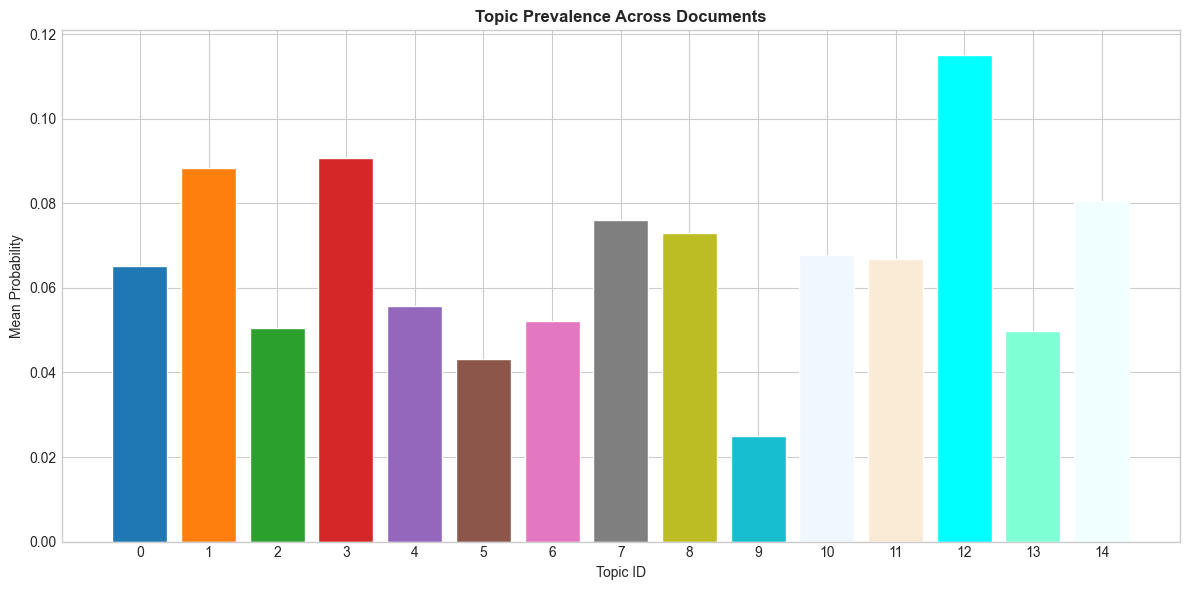

In [30]:
# Visualize prevalence
fig = visualizer.plot_topic_prevalence(prevalence)
plt.show()

## 2. Word Clouds

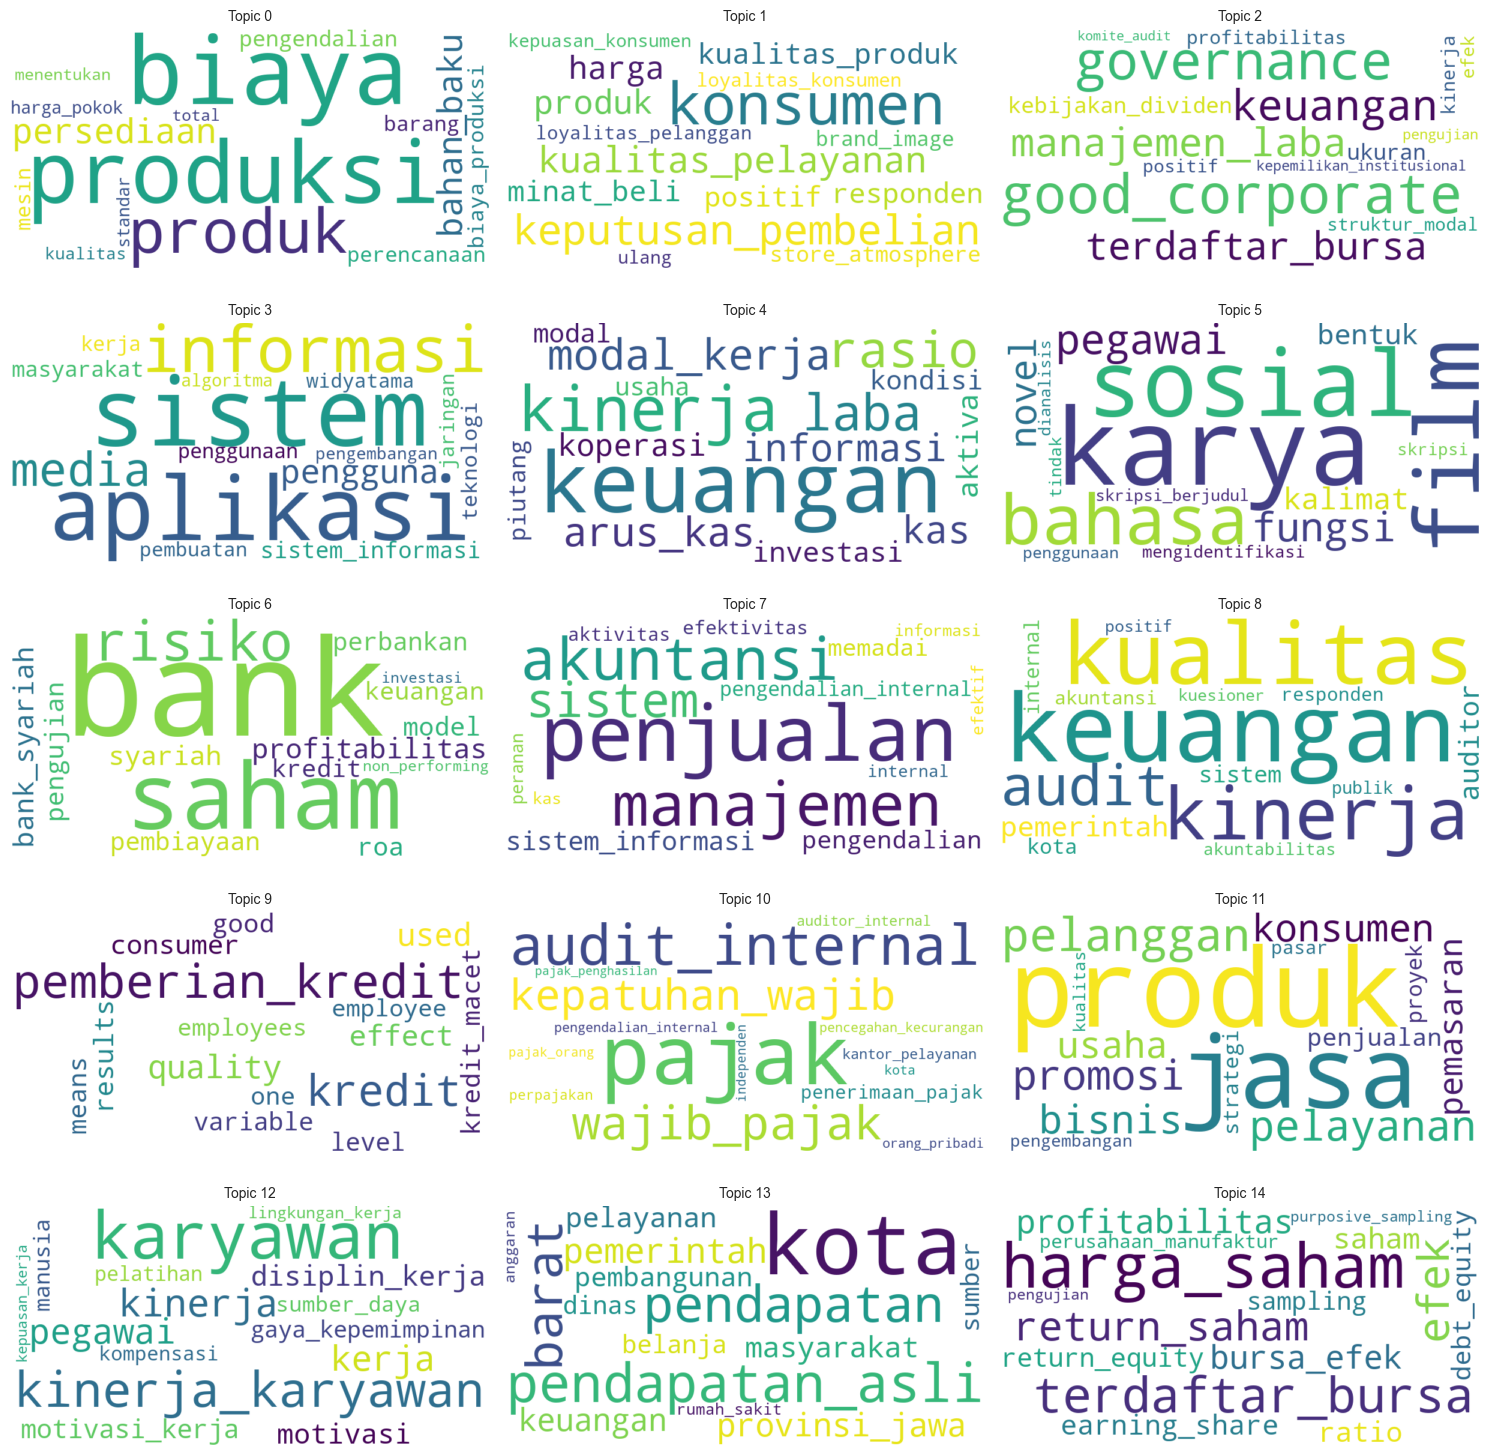

Saved to: C:\Users\alifn\PycharmProjects\topic-modeling-utama\outputs\wordclouds_all.png


In [31]:
# Word clouds for all topics
fig = visualizer.plot_all_wordclouds(num_words=15, cols=3)

# Save
wc_path = settings.outputs_dir / 'wordclouds_all.png'
fig.savefig(wc_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved to: {wc_path}")

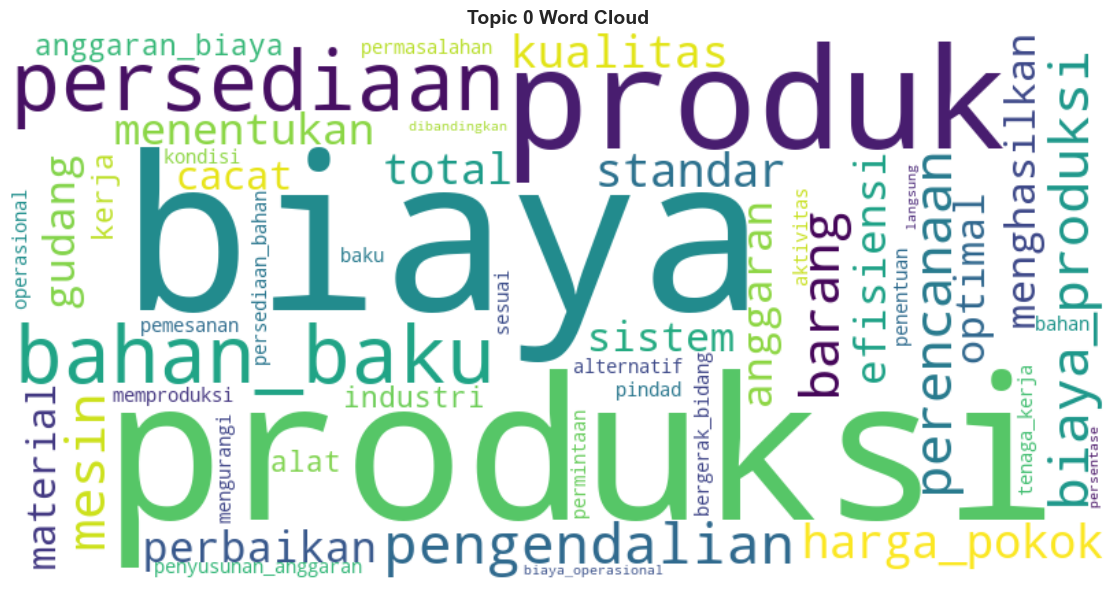

In [32]:
# Individual topic word cloud
TOPIC_TO_VIEW = 0  # Change this to view different topic

fig = visualizer.plot_wordcloud(TOPIC_TO_VIEW, num_words=50)
plt.show()

## 3. pyLDAvis Interactive Visualization

In [33]:
# Create and display pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

# Enable notebook mode
pyLDAvis.enable_notebook()

In [34]:
# Prepare visualization
vis_data = visualizer.create_pyldavis(
    processed_docs,
    save_path=settings.outputs_dir / 'pyldavis.html',
)

print(f"\nSaved pyLDAvis to: {settings.outputs_dir / 'pyldavis.html'}")

INFO:src.visualizations:Saved pyLDAvis to C:\Users\alifn\PycharmProjects\topic-modeling-utama\outputs\pyldavis.html



Saved pyLDAvis to: C:\Users\alifn\PycharmProjects\topic-modeling-utama\outputs\pyldavis.html


In [35]:
# Display interactive visualization
pyLDAvis.display(vis_data)

## 4. Topic Trends Over Time

In [36]:
# Compute topic trends by year
if 'year' in df.columns:
    trends = analyzer.compute_topic_trends(date_column='year', freq='Y')
    
    print("Topic trends computed")
    trends.head()

C:\Users\alifn\PycharmProjects\topic-modeling-utama\src\analysis.py:260: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  trends = df[topic_columns].resample(freq).mean()


Topic trends computed


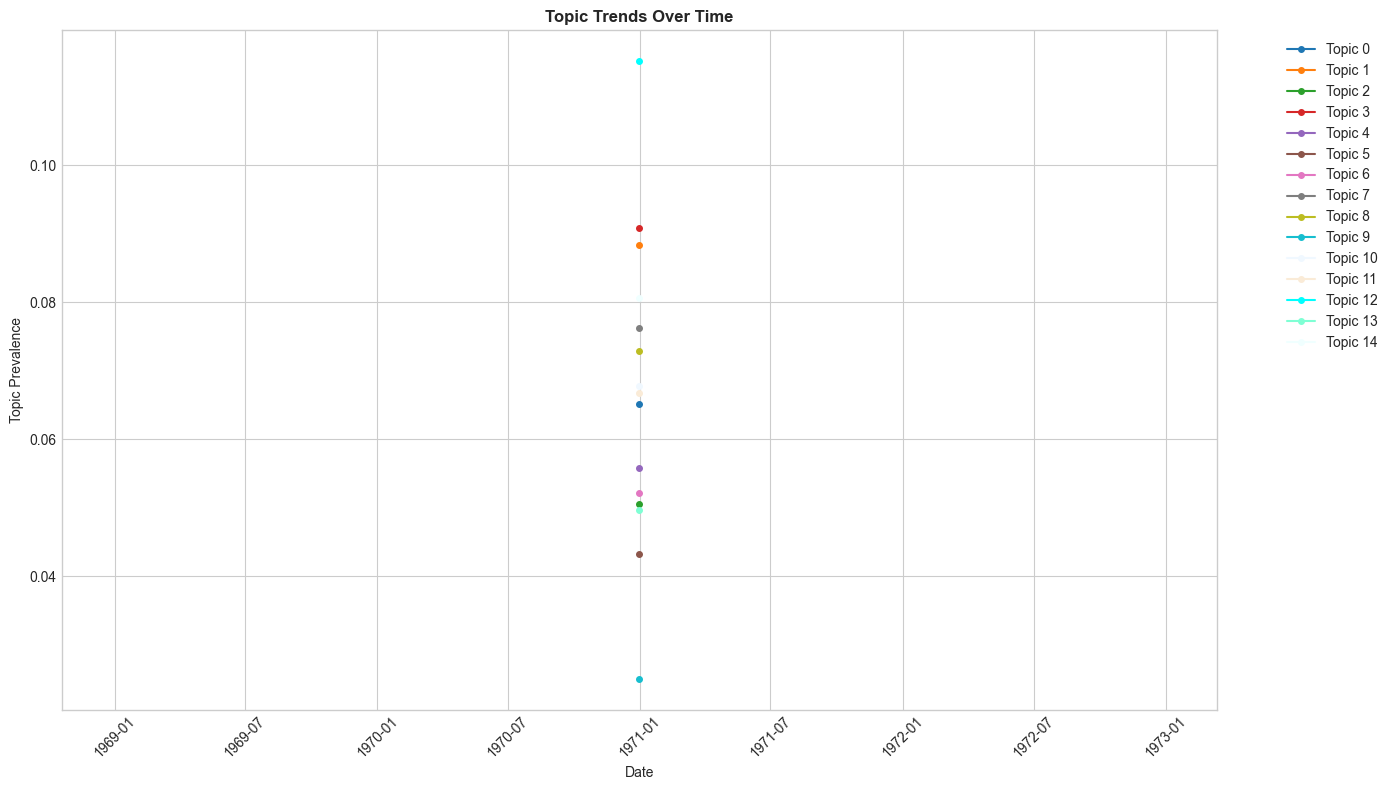

Saved to: C:\Users\alifn\PycharmProjects\topic-modeling-utama\outputs\topic_trends.png


In [37]:
# Visualize trends
if 'year' in df.columns:
    fig = visualizer.plot_topic_trends(trends, date_column='_date')
    
    # Save
    trends_path = settings.outputs_dir / 'topic_trends.png'
    fig.savefig(trends_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Saved to: {trends_path}")

## 5. Document Similarity Search

In [38]:
# Find similar documents to a specific document
DOCUMENT_INDEX = 0  # Change to explore different documents

# Display the query document
query_doc = df.iloc[DOCUMENT_INDEX]
print("Query Document:")
print("=" * 60)
print(f"Title: {query_doc['title']}")
print(f"\nAbstract: {query_doc['abstract'][:300]}...")

Query Document:
Title: PENGARUH BUDAYA KESELAMATAN DAN KESEHATAN KERJA (K3) DAN PROSEDUR KERJA TERHADAP PRODUKTIVITAS KERJA DI DIVISI ENGINEERING PT GANI ARTA DWITUNGGAL BANDUNG

Abstract: Tujuan penelitian ini adalah untuk mengetahui pengaruh budaya keselamatan dan kesehatan kerja (K3) terhadap produktivitas kerja di Divisi Engineering PT Gani Arta Dwitunggal Bandung. Serta, mengetahui pengaruh prosedur kerja terhadap produktivitas kerja di Divisi Engineering PT Gani Arta Dwitunggal ...


In [39]:
# Find similar documents
similar_docs = analyzer.find_similar_documents(DOCUMENT_INDEX, top_n=5)

print("\nMost Similar Documents:")
print("-" * 60)
for i, (_, row) in enumerate(similar_docs.iterrows()):
    print(f"\n{i+1}. (Similarity: {row['similarity']:.3f})")
    print(f"   Title: {row['title'][:70]}..." if len(row['title']) > 70 else f"   Title: {row['title']}")


Most Similar Documents:
------------------------------------------------------------

1. (Similarity: 1.000)
   Title: PENGARUH MOTIVASI KERJA KERJA TERHADAP PRESTASI KERJA ANGGOTA PADA SUB...

2. (Similarity: 1.000)
   Title: PENGARUH GAYA KEPEMIMPINAN TERHADAP MOTIVASI KERJA KARYAWAN PADA PT PO...

3. (Similarity: 1.000)
   Title: Pengaruh Gaya Kepemimpinan Terhadap Motivasi Kerja Karyawan Pada Hotel...

4. (Similarity: 1.000)
   Title: Hubungan Budaya Organisasi Dengan Prestasi Kerja Karyawan

5. (Similarity: 1.000)
   Title: PENGARUH KOMPENSASI TERHADAP PRODUKTIVITAS TENAGA KERJA (Studi Kasus p...


## 6. Topic Comparison

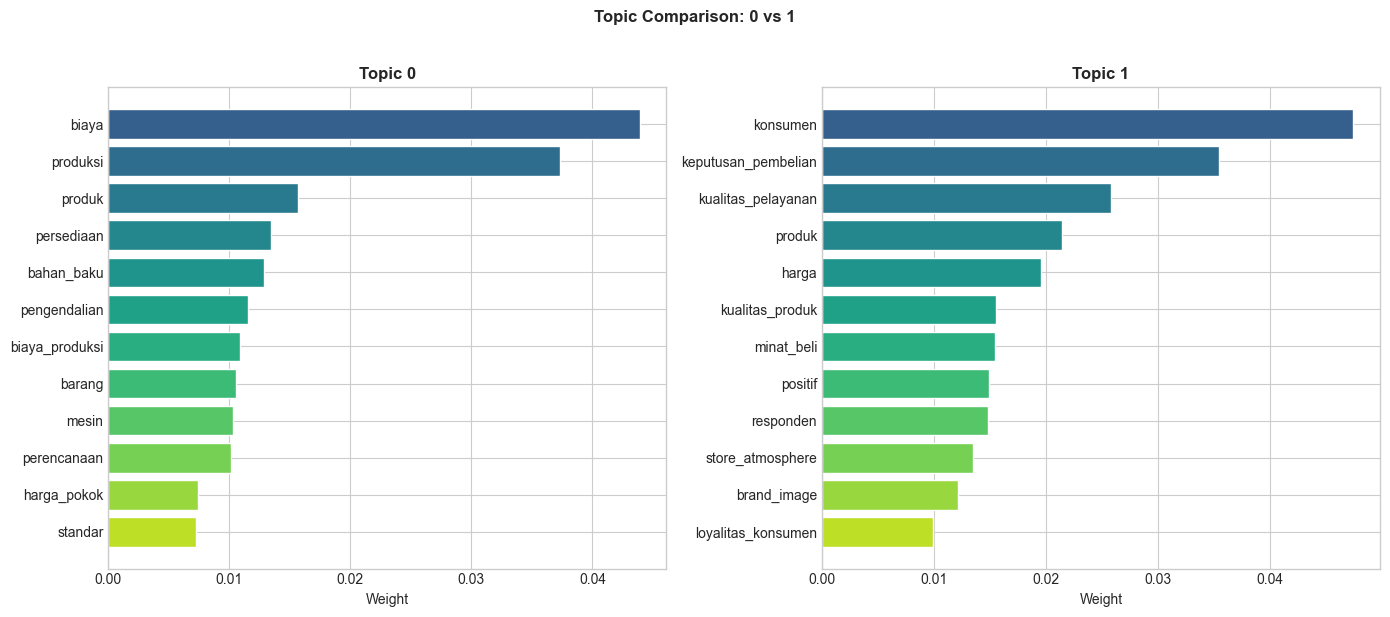

In [40]:
# Compare two topics
TOPIC_A = 0
TOPIC_B = 1

fig = visualizer.plot_topic_comparison(TOPIC_A, TOPIC_B, num_words=12)
plt.show()

In [41]:
# Analyze topic overlap
overlap = analyzer.get_topic_overlap(TOPIC_A, TOPIC_B, num_words=20)

print(f"Topic {TOPIC_A} vs Topic {TOPIC_B} Overlap Analysis:")
print("=" * 50)
print(f"Jaccard Similarity: {overlap['jaccard_similarity']:.3f}")
print(f"\nShared words: {', '.join(overlap['shared_words'][:10])}")
print(f"\nUnique to Topic {TOPIC_A}: {', '.join(overlap['unique_to_a'][:5])}")
print(f"Unique to Topic {TOPIC_B}: {', '.join(overlap['unique_to_b'][:5])}")

Topic 0 vs Topic 1 Overlap Analysis:
Jaccard Similarity: 0.026

Shared words: produk

Unique to Topic 0: menghasilkan, mesin, kualitas, persediaan, biaya
Unique to Topic 1: responden, loyalitas_konsumen, kota, determinasi, konsumen


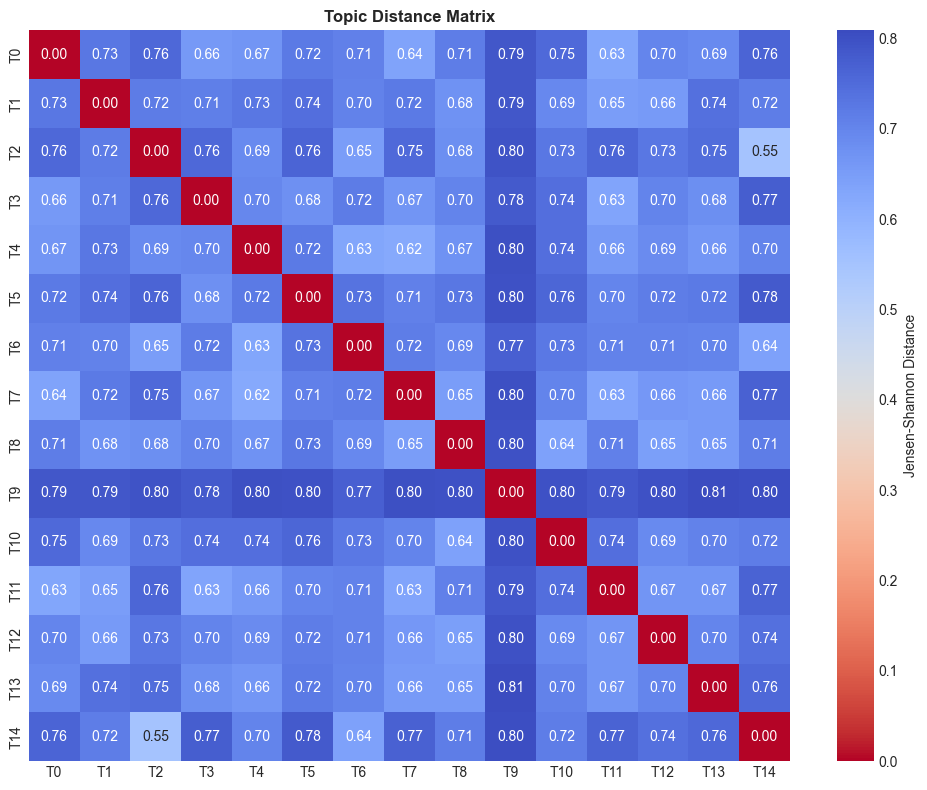

Saved to: C:\Users\alifn\PycharmProjects\topic-modeling-utama\outputs\topic_distances.png


In [42]:
# Topic distance matrix
distance_matrix = analyzer.compute_topic_distance_matrix()

fig = visualizer.plot_topic_distance_heatmap(distance_matrix)

# Save
dist_path = settings.outputs_dir / 'topic_distances.png'
fig.savefig(dist_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved to: {dist_path}")

## 7. Documents by Topic

In [43]:
# Get documents dominated by a specific topic
TOPIC_ID = 0

topic_docs = analyzer.get_documents_by_topic(TOPIC_ID, min_probability=0.3, top_n=10)

print(f"\nTop 10 Documents for Topic {TOPIC_ID}:")
print("=" * 60)

prob_col = f'topic_{TOPIC_ID}_prob'
for i, (_, row) in enumerate(topic_docs.iterrows()):
    print(f"\n{i+1}. (Prob: {row[prob_col]:.3f})")
    title = row['title']
    print(f"   {title[:75]}..." if len(title) > 75 else f"   {title}")


Top 10 Documents for Topic 0:

1. (Prob: 0.992)
   Analisis Penerapan Material Requirement Planning (MRP) dalam Upaya Mengenda...

2. (Prob: 0.991)
   ANALISIS JUMLAH PEMESANAN (Qs) DAN BIAYA TOTAL (Tc) BAHAN BAKU MAKANAN (STU...

3. (Prob: 0.991)
   Analisis Peranan MRP (Material Requirement Planning) Untuk Produk Kursi Ben...

4. (Prob: 0.990)
   ANALISIS PERSEDIAAN BAHAN BAKU KULIT SAPI DENGAN MENGGUNAKAN METODE ECONOMI...

5. (Prob: 0.990)
   PERENCANAAN KEBUTUHAN BAHAN SETENGAH JADI PRODUK DISTRIBUTOR VALVE MENGGUNA...

6. (Prob: 0.989)
   PENGENDALIAN PERSEDIAAN SPARE PART PADA PROSES REPAIR ENGINE CT7 MENGGUNAKA...

7. (Prob: 0.988)
   PERANCANGAN ALAT PENGUJIAN PEGAS PADA SUSPENSI SEPEDA MOTOR MENGGUNAKAN SOF...

8. (Prob: 0.987)
   ANALISIS PLANT LAYOUT PADA PERUSAHAAN PT. TEODORE PAN GARMINDO GARMENT MANU...

9. (Prob: 0.985)
   ANALISIS PERSEDIAAN BAHAN BAKU DENGAN METODE JUST IN TIME UNTUK MENGENDALIK...

10. (Prob: 0.984)
   ANALISIS KEBIJAKAN PERSEDIAAN SUKU CADANG MULTI

## 8. Document-Topic Heatmap

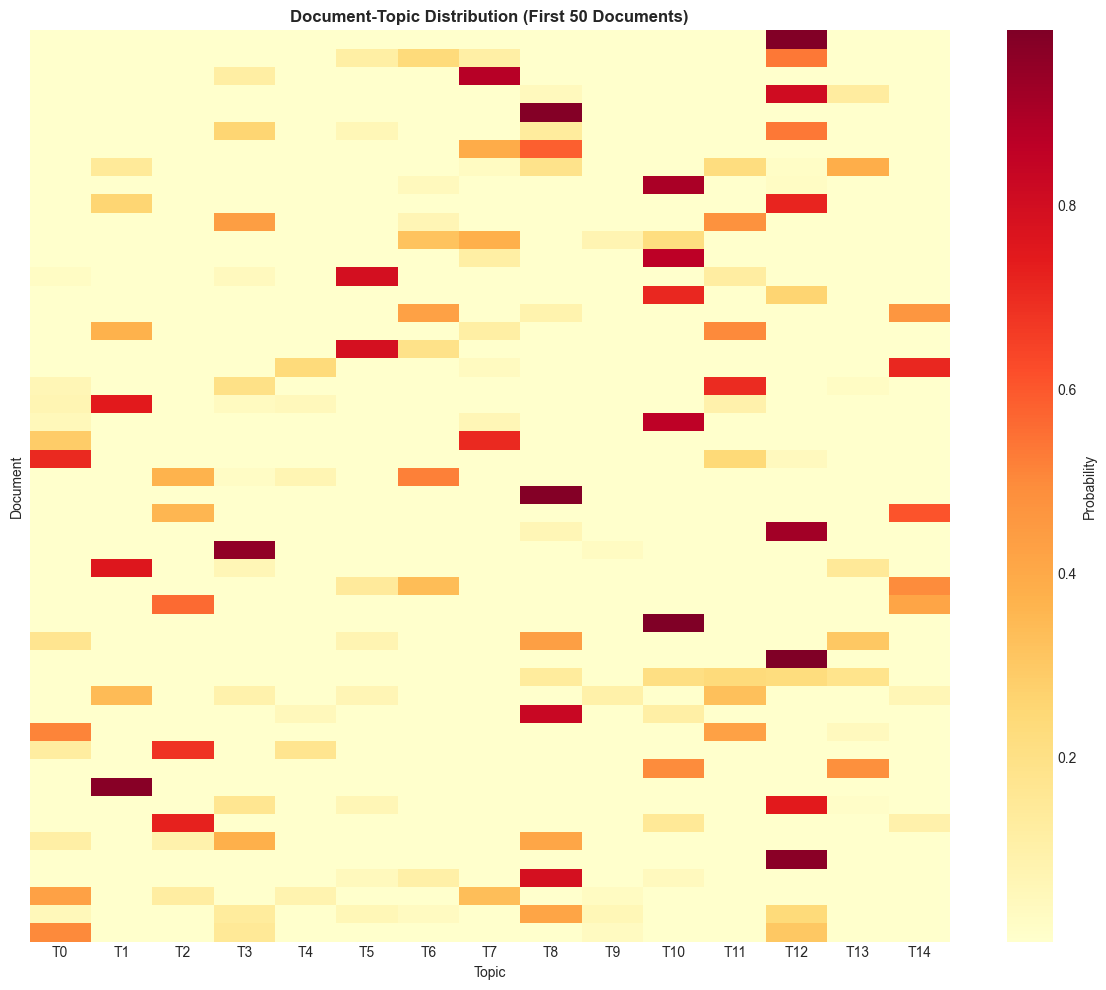

Saved to: C:\Users\alifn\PycharmProjects\topic-modeling-utama\outputs\doc_topic_heatmap.png


In [44]:
# Get topic matrix
topic_matrix = model.get_document_topic_matrix(processed_docs, show_progress=False)

# Plot heatmap for first 50 documents
fig = visualizer.plot_document_topic_heatmap(topic_matrix, num_docs=50)

# Save
heatmap_path = settings.outputs_dir / 'doc_topic_heatmap.png'
fig.savefig(heatmap_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved to: {heatmap_path}")

## 9. Save All Visualizations

In [45]:
# Save all visualizations to outputs directory
print("Saving all visualizations...")

viz_paths = visualizer.save_all_visualizations(
    processed_docs,
    topic_matrix,
    prevalence,
)

print("\n✅ All visualizations saved:")
for name, path in viz_paths.items():
    print(f"   - {name}: {path}")

Saving all visualizations...


INFO:src.visualizations:Saved word clouds to C:\Users\alifn\PycharmProjects\topic-modeling-utama\outputs\wordclouds_all.png
INFO:src.visualizations:Saved pyLDAvis to C:\Users\alifn\PycharmProjects\topic-modeling-utama\outputs\pyldavis.html
INFO:src.visualizations:Saved all visualizations to C:\Users\alifn\PycharmProjects\topic-modeling-utama\outputs



✅ All visualizations saved:
   - wordclouds: C:\Users\alifn\PycharmProjects\topic-modeling-utama\outputs\wordclouds_all.png
   - prevalence: C:\Users\alifn\PycharmProjects\topic-modeling-utama\outputs\topic_prevalence.png
   - heatmap: C:\Users\alifn\PycharmProjects\topic-modeling-utama\outputs\doc_topic_heatmap.png
   - pyldavis: C:\Users\alifn\PycharmProjects\topic-modeling-utama\outputs\pyldavis.html


## Summary

In [46]:
print("\n" + "=" * 60)
print("ANALYSIS AND VISUALIZATION COMPLETE")
print("=" * 60)

print(f"\n📊 Model: {model.model.num_topics} topics")
print(f"📈 Coherence: {model.metadata.coherence_score:.4f}")
print(f"📚 Documents: {len(processed_docs):,}")

print(f"\n📁 Output files saved to: {settings.outputs_dir}")

print(f"\n🚀 Launch the dashboard with:")
print(f"   streamlit run dashboard/app.py")


ANALYSIS AND VISUALIZATION COMPLETE

📊 Model: 15 topics
📈 Coherence: 0.6174
📚 Documents: 12,055

📁 Output files saved to: C:\Users\alifn\PycharmProjects\topic-modeling-utama\outputs

🚀 Launch the dashboard with:
   streamlit run dashboard/app.py
